# Modelamiento

In [9]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.MLDS6_Assets.database import deleteDirectoryAndContents
from src.MLDS6_Assets.preprocessing import countFilesinFolder
from src.MLDS6_Assets.visualization import plotDataPartition
from src.MLDS6_Assets.models import trainTestSplitImages
from src.MLDS6_Assets.callbacks import create_callbacks
from src.MLDS6_Assets.models import configModelV1, configModelV2
from src.MLDS6_Assets.training import train_model, plot_training_history


## Partición de datos

Para la partición de datos, vamos a tomar de base los datos unidos y balanceados en un único dataset. Para realizar la partición, usaremos la función train test split de sklearn y mantener el esquema de carpetas

In [10]:
trainTestSplitImages('../data',
                    '../splitData/temp',
                    '../splitData/test',
                    test_size = 0.1,
                    random_state = 42)

Split from 
../data
to
../splitData/temp
and
../splitData/test
was done successfully


In [11]:
trainTestSplitImages('../splitData/temp',
                    '../splitData/train',
                    '../splitData/val',
                    test_size = 0.1,
                    random_state = 42)

Split from 
../splitData/temp
to
../splitData/train
and
../splitData/val
was done successfully


In [12]:
deleteDirectoryAndContents('../data')
deleteDirectoryAndContents('../splitData/temp')
os.rename('../splitData','../data')

Deleted directory and all contents: ../data
Deleted directory and all contents: ../splitData/temp


Verificamos que las clases esten balanceados

In [13]:
dirs = [
  '../data/train/Normal',
  '../data/test/Normal',
  '../data/val/Normal',
  '../data/train/bacterialPneumonia',
  '../data/test/bacterialPneumonia',
  '../data/val/bacterialPneumonia',
  '../data/train/virusPneumonia',
  '../data/test/virusPneumonia',
  '../data/val/virusPneumonia'
]

s = {}
for dir in dirs:
  keys = dir.split('/')[2:]
  if keys[0] not in s: s[keys[0]] = {}
  if keys[1] not in s[keys[0]]: s[keys[0]][keys[1]] = countFilesinFolder(dir)

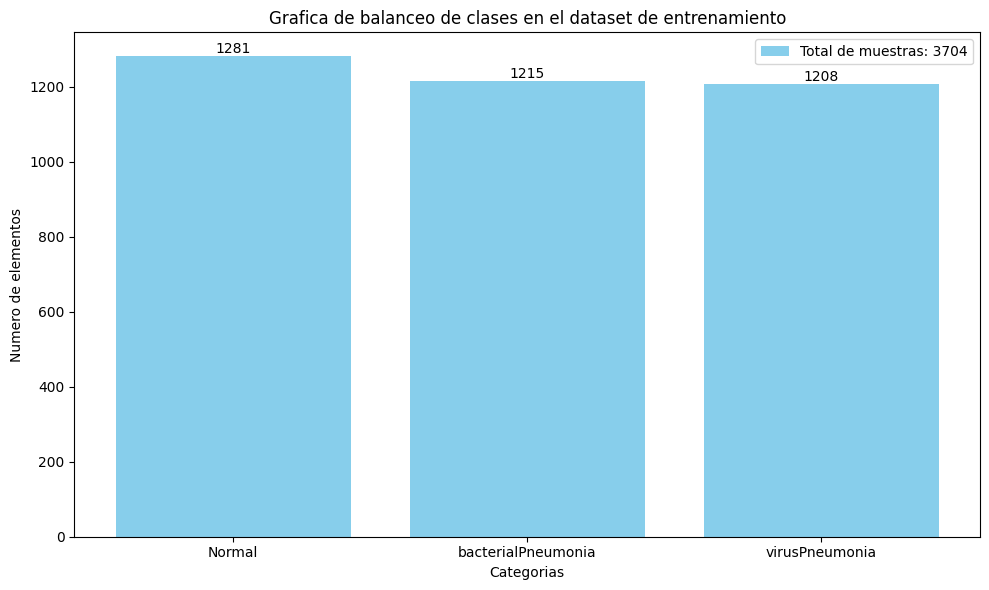

In [14]:
plotDataPartition(s['train'], 'Grafica de balanceo de clases en el dataset de entrenamiento')

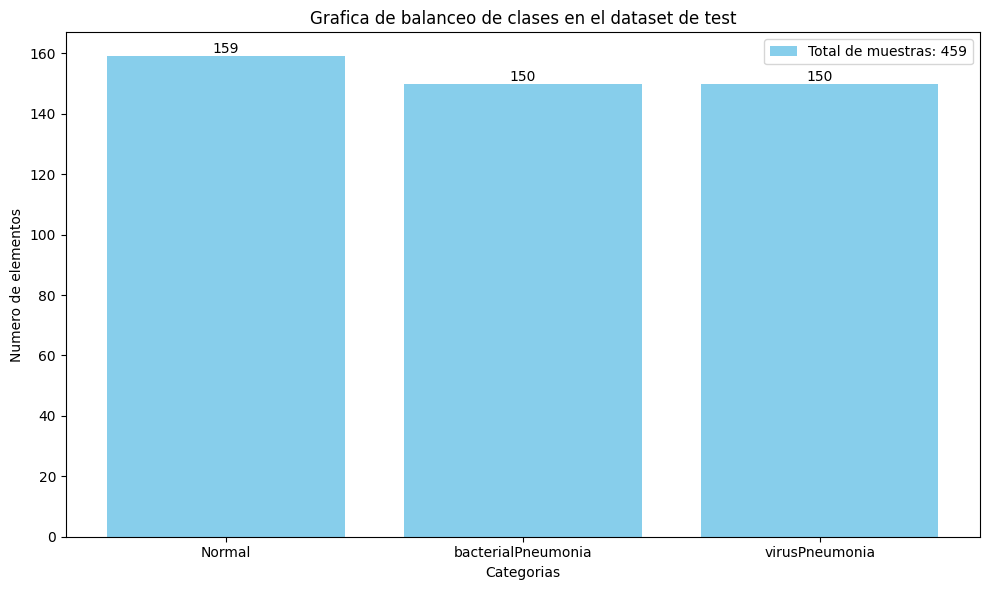

In [15]:
plotDataPartition(s['test'], 'Grafica de balanceo de clases en el dataset de test')

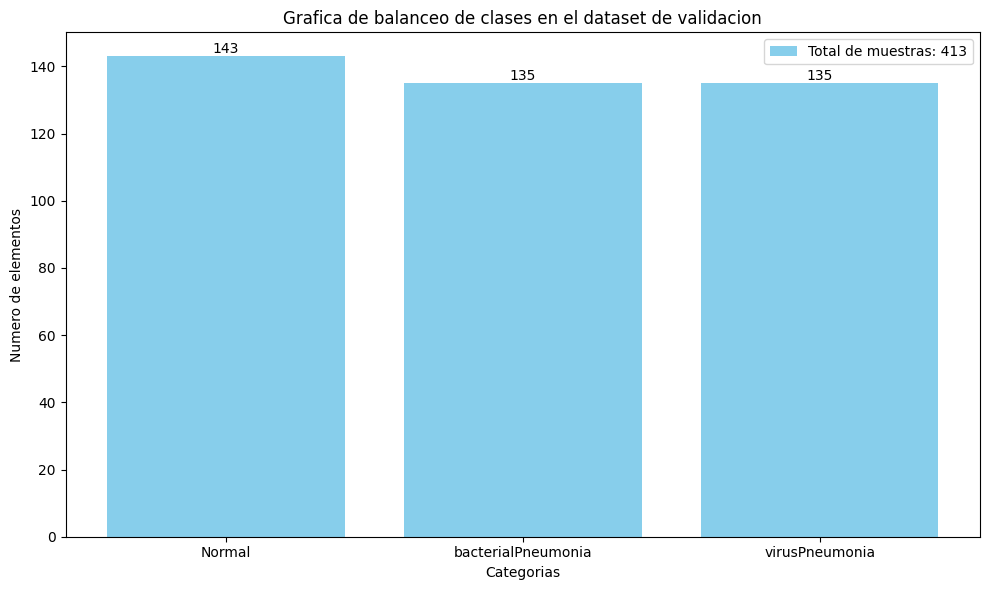

In [16]:
plotDataPartition(s['val'], 'Grafica de balanceo de clases en el dataset de validacion')

## Selección y diseño de modelos

Para abordar el problema de clasificación de imágenes en el diagnóstico de neumonía a partir de radiografías, hemos seleccionado los modelos VGG16 y EfficientNetB0, ambos disponibles en TensorFlow. Esta elección se justifica debido a que ambos modelos son redes neuronales convolucionales bien probadas en tareas de reconocimiento de imágenes y permiten capturar características visuales esenciales en radiografías. VGG16, con su arquitectura profunda y secuencial, es eficaz en detectar patrones sutiles y texturas asociadas a los signos de neumonía, como opacidades pulmonares; mientras que EfficientNetB0 se distingue por su capacidad de procesamiento optimizada y eficiente, lo que es ideal para implementaciones en tiempo real sin comprometer precisión. Además, se implementará transfer learning utilizando modelos preentrenados, lo que permitirá aprovechar características previamente aprendidas en grandes conjuntos de datos, acelerando el entrenamiento y mejorando la generalización en nuestro conjunto de datos específico. Al combinar ambos modelos, podemos lograr un balance entre precisión y velocidad, mejorando la fiabilidad diagnóstica. Además, ambos modelos se pueden adaptar añadiendo capas densas y técnicas como dropout o normalización para ajustarse mejor a las necesidades específicas del conjunto de datos, maximizando así el rendimiento en la tarea de clasificación.



### Carga de modelos pre entrenados y configuracion de mlops

A continuación, comenzamos definiendo las funciones necesarias para pre-cargar los modelos VGG16 y EfficientNetB0, los cuales serán modificados y adaptados para abordar el problema en cuestión. Es importante señalar que, aunque se crearán las funciones correspondientes, no se ejecutarán hasta el final. Esto se hará con el propósito de mantener un orden claro y ejecutar todo de manera estructurada en la última fase del proceso.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0

# Carga del modelo base preentrenado
model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(765, 500, 3))
#Congelamos capas
for layer in model_efficientnet.layers:
    layer.trainable = False

# Configura el modelo completo con diferentes versiones
model_v1 = configModelV1(model_efficientnet, lr=1e-3)
model_v2 = configModelV2(model_efficientnet, lr=1e-3)

input_shape = (765, 500, 3)

# Cargar modelos base
model_VGG16 = tf.keras.applications.VGG16(weights='imagenet',
                                          include_top=False,
                                          input_shape=(765, 500, 3))

#Congelamos capas
for layer in model_VGG16.layers:
    layer.trainable = False
# Configurar modelos completos
model_VGG16_v1 = configModelV1(model_VGG16, lr=1e-3)
model_VGG16_v2 = configModelV2(model_VGG16, lr=1e-3)


### Creacion de callbacks
se configuran funciones automáticas que se ejecutan durante el entrenamiento para optimizar el proceso. Estas incluyen guardar el mejor modelo (ModelCheckpoint), detener el entrenamiento si no hay mejora en un tiempo (EarlyStopping), y reducir el learning rate si el modelo deja de mejorar (ReduceLROnPlateau). Estas herramientas ayudan a evitar el sobreajuste y a ajustar el modelo de forma más eficiente.








In [ ]:
# Crear callbacks para cada modelo
callbacks_VGG16_v1 = create_callbacks("VGG16_v1")
callbacks_VGG16_v2 = create_callbacks("VGG16_v2")
callbacks_EfficientNetB0_v1 = create_callbacks("EfficientNetB0_v1")
callbacks_EfficientNetB0_v2 = create_callbacks("EfficientNetB0_v2")


### Personalizacion de los modelos
Recordemos que nuestro objetivo es adaptar estos modelos a una arquitectura diferente para tener una mejor aproximacion al problema, por lo cual, generamos una funcion que genere dos configuraciones de capas densas al final de este que nos permita generar distintos modelos para comparar. Con esto, la idea es generar cuatro modelos entrenables diferentes que se puedan entrenar y evaluar

In [ ]:
# Modelos basados en VGG16
model_VGG16_v1 = configModelV1(model_VGG16, lr=1e-3)
model_VGG16_v2 = configModelV2(model_VGG16, lr=1e-3)

# Modelos basados en EfficientNetB0
model_EfficientNetB0_v1 = configModelV1(model_efficientnet, lr=1e-3)
model_EfficientNetB0_v2 = configModelV2(model_efficientnet, lr=1e-3)


### Entrenamiento del modelo usando Mlflow
Una vez definido todo lo anterior, definimos una funcion para que mlflow para que empiece a realizar los entrenamientos correspondientes

In [ ]:
 # Datos de entrenamiento
train_data = ... 
# Datos de validación
validation_data = ...  

# Entrenar modelos VGG16
history_VGG16_v1 = train_model(model_VGG16_v1, "VGG16_v1", train_data, validation_data, epochs=10)
history_VGG16_v2 = train_model(model_VGG16_v2, "VGG16_v2", train_data, validation_data, epochs=10)

# Entrenar modelos EfficientNetB0
history_EfficientNetB0_v1 = train_model(model_EfficientNetB0_v1, "EfficientNetB0_v1", train_data, validation_data, epochs=10)
history_EfficientNetB0_v2 = train_model(model_EfficientNetB0_v2, "EfficientNetB0_v2", train_data, validation_data, epochs=10)


### Historial de entrenamiento
Es importante tambien destacar los historiales de entrenamiento, por lo cual se realiza el graficado tal como se ve a continuacion:

In [ ]:
# Visualizar entrenamientos de VGG16
plot_training_history(history_VGG16_v1, "VGG16_v1")
plot_training_history(history_VGG16_v2, "VGG16_v2")

# Visualizar entrenamientos de EfficientNetB0
plot_training_history(history_EfficientNetB0_v1, "EfficientNetB0_v1")
plot_training_history(history_EfficientNetB0_v2, "EfficientNetB0_v2")
